# What did lockdown do to transport emissions and fuel use in the UK?
Looking at emissions, fuel duty receipts, traffic data and fuel consumption data

In [2]:
# Importing packages

# Data importing
import requests
import openpyxl
# import odf_py

# Data wrangling and processing
import pandas as pd
import numpy as np

# Data viz
import seaborn as sns
from matplotlib import pyplot as plt

This notebook builds on the work done in 5a) Predicting covid's effect on fuel consumption. We had little data in that set - car numbers, vehicle miles, traffic levels and fuel consumption. Now we'll look at a wider set of data.

## Steps involved:

1. Import historic fuel duty data and clean up
2. Import historic emissions data and clean up
3. Explore relationship between our data
4. Make some predictions

### Step 1) Import fuel duty data

ONS public finances bulletin has monthly fuel duty receipts, published every quarter

In [3]:
# Import xlsx
fuel_duty_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/962074/NS_Receipts_Table_Published.xlsx'
fd = pd.read_excel(fuel_duty_url, sheet_name='Receipts Published', engine='openpyxl')

# Remove bumpf, assign new columns, strip out other tax receipts
new_columns = fd.iloc[4]
fd.columns = new_columns
fd = fd[6:]
fd = fd[['Financial Year','Hydrocarbon Oil (Fuel duties)']]

# Do some indexy things
fd.reset_index(inplace=True, drop=True)

# Rename columns
fd = fd.rename(columns={'Financial Year': 'f_year', 'Hydrocarbon Oil (Fuel duties)': 'fuel_duty'})
fd = fd[21:].reset_index(drop=True)

#Change dtypes to more appropriate object types
fd['f_year'] = fd['f_year'].apply(lambda x: pd.to_datetime(x))
fd['fuel_duty'] = fd['fuel_duty'].apply(lambda x: pd.to_numeric(x))

In [4]:
fd.head()
# fuel_duty is millions of pounds

4,f_year,fuel_duty
0,2008-04-01,2131
1,2008-05-01,2081
2,2008-06-01,2132
3,2008-07-01,2041
4,2008-08-01,2030


Text(0.5, 1.0, 'Fuel duty receipts in £m since 2008, monthly')

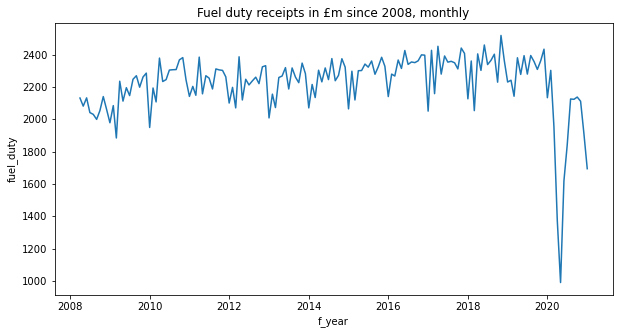

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fd, x='f_year', y='fuel_duty')
plt.title('Fuel duty receipts in £m since 2008, monthly')

Text(0.5, 1.0, 'Fuel duty over the course of 2019, 2020 and 2021')

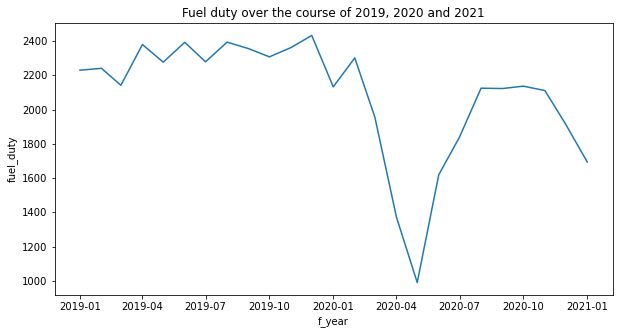

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fd[fd['f_year'] > '2018-12-01'], x='f_year', y='fuel_duty')
plt.title('Fuel duty over the course of 2019, 2020 and 2021')

### Step 2) Import emissions data

Bit more complex - we'll look at total GHGs as CO2e.

Data are from the National Atmospheric Emissions Inventory.

In [7]:
em_url = 'https://naei.beis.gov.uk/data/download?q=142397&section=ukdata&pollutantId=Total%20GHGs%20in%20CO2%20Eq.'
em = pd.read_csv(em_url)
em = em[em['NFR/CRF Group'] == '1A']
em = em.T.reset_index()
new_cols = em.iloc[4]
em.columns = new_cols
em = em[5:].reset_index(drop='True')
em.columns = ['year', 'kt_co2e']
em['kt_co2e'] = em['kt_co2e'].apply(lambda x: pd.to_numeric(x))
em['year'] = em['year'].apply(lambda x: pd.to_datetime(x))

In [8]:
em.tail(10)

,year,kt_co2e
19,2009-01-01,112238.071731
20,2010-01-01,110899.420243
21,2011-01-01,109416.748544
22,2012-01-01,109084.572699
23,2013-01-01,108260.946219
24,2014-01-01,109739.777438
25,2015-01-01,111973.845869
26,2016-01-01,114585.172396
27,2017-01-01,114785.965097
28,2018-01-01,113280.299295


Text(0.5, 1.0, 'UK road transport emissions, kt CO2e')

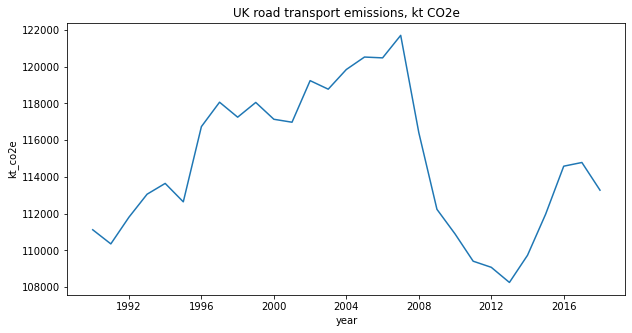

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=em, x='year', y='kt_co2e')
plt.title('UK road transport emissions, kt CO2e')

### Step 3) Explore relationship between Road Transport Emissions and Fuel Duty

In [10]:
eml = em[em['year'] > '2009-12-31']

In [11]:
fdl = fd[fd['f_year'] > '2009-12-31']

In [12]:
fdl.head()

4,f_year,fuel_duty
21,2010-01-01,1949
22,2010-02-01,2193
23,2010-03-01,2107
24,2010-04-01,2378
25,2010-05-01,2233


In [13]:
eml.tail()

,year,kt_co2e
24,2014-01-01,109739.777438
25,2015-01-01,111973.845869
26,2016-01-01,114585.172396
27,2017-01-01,114785.965097
28,2018-01-01,113280.299295


We need to turn our fuel duty data into annual totals.

In [14]:
fdl['year'] = pd.DatetimeIndex(fdl['f_year']).year

<ipython-input-14-98a3e5f8ce92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdl['year'] = pd.DatetimeIndex(fdl['f_year']).year


In [15]:
fdy = fdl[['fuel_duty', 'year']]

In [16]:
fdy = fdl.groupby('year').sum().reset_index(drop=False)

In [17]:
fdy18 = fdy[:9]

In [18]:
fdy18

4,year,fuel_duty
0,2010,27013
1,2011,26923
2,2012,26703
3,2013,26698
4,2014,27095
5,2015,27416
6,2016,27989
7,2017,27973
8,2018,27919


Now to extract year into a new column in eml. 

In [19]:
eml['year'] = pd.DatetimeIndex(eml['year']).year

<ipython-input-19-c601028b34d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eml['year'] = pd.DatetimeIndex(eml['year']).year


In [20]:
eml.reset_index(drop=True, inplace=True)

In [21]:
eml.tail()

,year,kt_co2e
4,2014,109739.777438
5,2015,111973.845869
6,2016,114585.172396
7,2017,114785.965097
8,2018,113280.299295


In [22]:
df = pd.merge(fdy, eml, how='left', on='year')

In [65]:
df.set_index('year', inplace=True)

In [66]:
df.head()

,fuel_duty,kt_co2e
year,,
2010,27013,110899.420243
2011,26923,109416.748544
2012,26703,109084.572699
2013,26698,108260.946219
2014,27095,109739.777438


In [67]:
df.dtypes

fuel_duty      int64
kt_co2e      float64
dtype: object

#### Using SKLearn

In [69]:
from sklearn import preprocessing

In [70]:
scaler = preprocessing.MinMaxScaler()

In [71]:
df[df.columns] = scaler.fit_transform(df[df.columns])

In [72]:
df.head()

,fuel_duty,kt_co2e
year,,
2010,0.962883,0.404363
2011,0.959460,0.177134
2012,0.951093,0.126226
2013,0.950903,0.000000
2014,0.966001,0.226640


Text(0.5, 1.0, 'Normalized fuel duty receipts and road transport emissions')

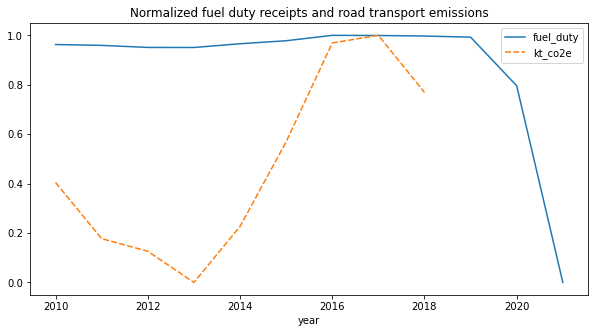

In [79]:
plt.figure(figsize=(10, 5))
sns.lineplot(data = df)
plt.title('Normalized fuel duty receipts and road transport emissions')

#### Attempting to use Tensorflow
We're going to try to do use tensorflow.

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [37]:
raw_dataset = df.set_index('year', drop=True)
dataset = raw_dataset.copy()

#Raw dataset has years up to 2021 for fuel duty receipts.
dataset = dataset[:9]
dataset.tail()

,fuel_duty,kt_co2e
year,,
2014,27095,109739.777438
2015,27416,111973.845869
2016,27989,114585.172396
2017,27973,114785.965097
2018,27919,113280.299295


In [38]:
dataset.isna().sum()

fuel_duty    0
kt_co2e      0
dtype: int64

In [39]:
# Split the data into testing and training
train_dataset = dataset.sample(frac =0.8, random_state =0)
test_dataset = dataset.drop(train_dataset.index)

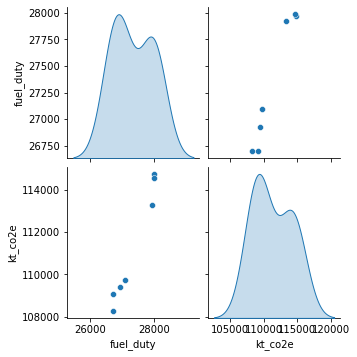

In [40]:
sns.pairplot(train_dataset[['fuel_duty', 'kt_co2e']], diag_kind='kde')

In [41]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fuel_duty,7.0,27328.571429,606.638788,26698.000000,26813.000000,27095.000000,27946.000000,27989.000000
kt_co2e,7.0,111307.640241,2798.522929,108260.946219,109250.660622,109739.777438,113932.735845,114785.965097


In [42]:
# Split the features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('kt_co2e')
test_labels = test_features.pop('kt_co2e')

Now normalise

In [45]:
normalizer = preprocessing.Normalization()

In [46]:
normalizer.adapt(np.array(train_features))

In [47]:
print(normalizer.mean.numpy())

[27328.572]


In [49]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First example:  [[27973]]

Normalized:  [[1.15]]


In [50]:
fuel_duty = np.array(train_features['fuel_duty'])

In [51]:
fuel_duty_normalizer = preprocessing.Normalization(input_shape=[1,])
fuel_duty_normalizer.adapt(fuel_duty)

In [52]:
fuel_duty_model = tf.keras.Sequential([
    fuel_duty_normalizer,
    layers.Dense(units=1)
])

fuel_duty_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [53]:
fuel_duty_model.predict(fuel_duty[:10])

array([[-0.3800443 ],
       [ 0.36892447],
       [ 0.23918186],
       [ 0.13774672],
       [-0.34819838],
       [-0.3894801 ],
       [ 0.37187317]], dtype=float32)

In [54]:
fuel_duty_model.compile(
optimizer=tf.optimizers.Adam(learning_rate=0.1),
loss='mean_absolute_error')

In [55]:
%%time
history = fuel_duty_model.fit(
train_features['fuel_duty'], train_labels, epochs=100, verbose=0, validation_split=0.2)

Wall time: 3.93 s


In [56]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,111251.859375,111413.718750,95
96,111251.765625,111413.625000,96
97,111251.664062,111413.531250,97
98,111251.562500,111413.437500,98
99,111251.460938,111413.328125,99


In [63]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

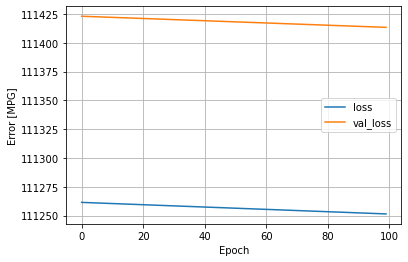

In [64]:
plot_loss(history)

In [59]:
test_results={}

test_results['fuel_duty_model'] = fuel_duty_model.evaluate(test_features['fuel_duty'], test_labels, verbose=0)

In [60]:
def plot_fuelduty(x, y):
  plt.scatter(train_features['fuel_duty'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('fuel_duty')
  plt.ylabel('kt_co2e')
  plt.legend()

In [61]:
x = tf.linspace(0.0, 250, 251)
y = fuel_duty_model.predict(x)

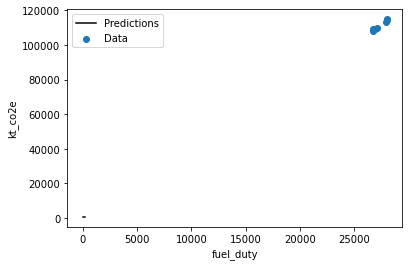

In [62]:
plot_fuelduty(x, y)